# Ширење на повторувачки епидемии

Ние можеме да ги моделираме ефектите на имунитетот на стадото со користење на идејата за болест која постојано се воведува во истата контактна мрежа - резаразливост. Ние дозволуваме болеста да поминува низ популацијата, а потоа забележуваме дека, за SIR инфекции, секој што е отстранет од популацијата, не може повторно да се инфицира, и навистина не учествува понатаму во динамиката на болеста. Остануваме со преостаната мрежа во која повторно ја воведуваме болеста со сеење на нови заразени лица и гледаме што ќе се случи.

```{margin} SIS модел
Постојат и други модели на болести како што е SIS предложен од 
Lajmanovich и Yorke [[17]](https://www.scirp.org/(S(351jmbntvnsjt1aadkposzje))/reference/ReferencesPapers.aspx?ReferenceID=2217583). Кај него луѓето стануваат подлежни повторно по инфекцијата, и овие може да се користат за проучување на ендемични болести кои остануваат активни подолго време. 

```

Важното нешто што треба да се забележи е дека втората епидемија е предизвикана од повторно воведување на истата болест, со иста инфективност и период на инфекција. Дали оваа инстанца на болеста ќе се прошири? - само ако преостанатата мрежа е таква што болеста може да се зафати во неа. Ако првата епидемија предизвикала отстранување на доволно јазли, тогаш ова може да спречи втора епидемија кај истата популација (или, поточно, во голема под-група на дел од популацијата која не била заразена прв пат).

Ова е уште еден начин да се размислува за **имунитетот на стадото**. Со отстранување на јазлите од популацијата, таа ја менува својата топологија така што размножувањето на болеста повеќе не е можно, или барем се случува на радикално помало ниво. Било какви последователни епидемии се во некоја смисла „скршени од топологијата“, иако биологијата на ситуацијата е непроменета.

Бидејќи ми беше поедноставно во кратко време да демонстрирам симулации, тука се вратив на ЕР мрежите. (Истите аргументи работат совршено добро и на **powerlaw мрежите** што би сакал да го истражам за дипломска работа). Во овој пример создаваме мала мрежа и ја спроведуваме SIR епидемијата, избирајќи параметри на болеста за кои знаеме дека ќе создадат епидемија.

## Симулација за колективен имунитет

- *топологија на мрежа*: ЕР 
- *модел*: SIR 
- $N$ *(поулација)*: 10 000 јазли

In [11]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 250
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=.75)
from IPython.display import Image



class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # набљудување и на останатите состојби
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [2]:
# Главни параметри
N = 10_000
kmean = 20

T = 5000

pInfected = 0.01
pInfect = 0.0002   # над самиот epidemic threshold
pRemove = 0.002

# Креирај граф
g = networkx.gnp_random_graph(N, (kmean + 0.0) / N)

# Постави параметри
param = dict()

param[epydemic.SIR.P_INFECTED] = pInfected
param[epydemic.SIR.P_INFECT] = pInfect
param[epydemic.SIR.P_REMOVE] = pRemove
param[epydemic.Monitor.DELTA] = T / 50

Сега можеме да видиме колку јазли биле заразени во текот на епидемијата (големината на одделот Р) и колку избегнале инфекција и остануваат подлежни:

In [3]:
m1 = MonitoredSIR()
e1 = epydemic.StochasticDynamics(m1, g)
rc1 = e1.set(param).run()


print('Останати подлежни, S(t)={s}; отстранети, R(t)={r}'.format(s=len(m1.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m1.compartment(epydemic.SIR.REMOVED))))

Останати подлежни, S(t)=2686; отстранети, R(t)=7314


Прилично голема епидемија, но која остави значителен број незаразени. Сега ја конструираме преостанатата мрежа со бришење на сите јазли кои се (или биле) заразени, оставајќи ги подложните. Ние не ги допираме рабовите помеѓу јазлите што остануваат.

In [4]:
h = m1.network().copy()
h.remove_nodes_from(m1.compartment(epydemic.SIR.INFECTED))
h.remove_nodes_from(m1.compartment(epydemic.SIR.REMOVED))

Како разумна проверка, бројот на јазли во преостанатата мрежа треба да одговара на бројот на подлежни јазли што останаа по првата епидемија.

In [5]:
print('Редослед на преостаната мрежа: {o}'.format(o=h.order()))

Редослед на преостаната мрежа: 2686


Сега ја извршуваме *истата* болест на оваа мрежа без да ги допираме експерименталните параметри.

In [6]:
m2 = MonitoredSIR()
e2 = epydemic.StochasticDynamics(m2, h)
rc2 = e2.set(param).run()

Кој е резултатот? Можеме да го прикажеме напредокот на двете епидемии рамо до рамо: **„главната“** епидемија и **„секундарната“** инфекција на преостанатата мрежа.

In [13]:
# Python3 imports 
from scipy.integrate import odeint
import numpy as np
import math
import plotly.graph_objects as go
import plotly.tools as tls
from plotly.validators.scatter.marker import SymbolValidator
from plotly.offline import plot, iplot, init_notebook_mode
from IPython.core.display import display, HTML
import epydemic
import networkx
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

init_notebook_mode(connected = True)
config={'showLink': False, 'displayModeBar': False}

fig = make_subplots(rows=1, cols=2, subplot_titles=("Прва пандемија", "Втора пандемија"))

# Прва пандемија
timeseries1 = rc1[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
sim_ts1 = timeseries1[epydemic.Monitor.OBSERVATIONS]
sim_ss1 = timeseries1[epydemic.SIR.SUSCEPTIBLE]
sim_is1 = timeseries1[epydemic.SIR.INFECTED]
sim_rs1 = timeseries1[epydemic.SIR.REMOVED]

fig.add_trace(go.Scatter(x = sim_ts1, 
                         y = sim_ss1, 
                         mode='lines',
                         visible = True,
                         marker_color="blue", 
                         name = "Подлежни; <i>S(t)</i><br><i>Прва пандемија</i>",
                         hovertemplate = '<i> %{y:.0f} </i> луѓе',\
                         xaxis="x1",
                         yaxis="y1",
                        ), row=1, col=1) 


fig.add_trace(go.Scatter(x = sim_ts1, 
                         y = sim_is1,
                         mode='lines',
                         visible = True,
                         marker_color="red", 
                         name = "Заразени; <i>I(t)</i><br><i>Прва пандемија</i>",
                         hovertemplate = '<i> %{y:.0f} </i> луѓе',
                         xaxis="x1",
                         yaxis="y1",), row=1, col=1)


fig.add_trace(go.Scatter(x = sim_ts1,
                         y = sim_rs1, 
                         mode='lines',
                         visible = True,
                         marker_color="green", 
                         name = "Отстранети; <i>R(t)</i><br><i>Прва пандемија</i>",
                         hovertemplate = '<i> %{y:.0f} </i> луѓе',
                         xaxis="x1",
                         yaxis="y1",), row=1, col=1)

# Вора пандемија 
timeseries2 = rc2[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
sim_ts2 = timeseries2[epydemic.Monitor.OBSERVATIONS]
sim_ss2 = timeseries2[epydemic.SIR.SUSCEPTIBLE]
sim_is2 = timeseries2[epydemic.SIR.INFECTED]
sim_rs2 = timeseries2[epydemic.SIR.REMOVED]

fig.add_trace(go.Scatter(x = sim_ts2, 
                         y = sim_ss2, 
                         mode='lines',
                         visible = True,
                         marker_color="blue", 
                         name = "Подлежни; <i>S(t)</i><br><i>Втора пандемија</i>",
                         hovertemplate = '<i> %{y:.0f} </i> луѓе',
                         xaxis="x2",
                         yaxis="y2"), row=1, col=2) 


fig.add_trace(go.Scatter(x = sim_ts2, 
                         y = sim_is2,
                         mode='lines',
                         visible = True,
                         marker_color="red", 
                         name = "Заразени; <i>I(t)</i><br><i>Втора пандемија</i>",
                         hovertemplate = '<i> %{y:.0f} </i> луѓе',
                         xaxis="x2",
                         yaxis="y2"), row=1, col=2)


fig.add_trace(go.Scatter(x = sim_ts2,
                         y = sim_rs2, 
                         mode='lines',
                         visible = True,
                         marker_color="green", 
                         name = "Отстранети; <i>R(t)</i><br><i>Втора пандемија</i>",
                         hovertemplate = '<i> %{y:.0f} </i> луѓе',
                         xaxis="x2",
                         yaxis="y2"), row=1, col=2)

# Изглед на фигура
fig.update_layout(title = 'Прогресија на две пандемии на иста мрежа', 
                  title_x = 0.5, 
                  xaxis1=dict(range=[0,8000], 
                              title='<i>t</i>',
                              mirror=False,
                             ticks='outside',
                             showline=True,
                             tickvals = [0, 2000, 4000, 6000, 8000],
                             linecolor='#000',
                             tickfont = dict(size=9)),
                  xaxis2=dict(range=[0,2500], 
                              title='<i>t</i>',
                             mirror=False,
                             ticks='outside',
                             showline=True,
                             tickvals = [0, 500, 1000, 1500, 2000, 2500],
                             linecolor='#000',
                             tickfont = dict(size=9)),
                  yaxis1=dict(range=[-100,10000], 
                              title='<i>N</i>',
                             mirror=False,
                             ticks='outside', 
                             showline=True,
                             showspikes = True,
                             linecolor='#000',
                             tickvals = [0, 2000, 4000, 6000, 8000, 10000], 
                             tickfont = dict(size=9)),
                  yaxis2=dict(range=[-100,10000], 
                             mirror=False,
                             ticks='outside', 
                             showline=True,
                             showspikes = True,
                             linecolor='#000',
                             tickvals = [0, 2000, 4000, 6000, 8000, 10000], 
                             tickfont = dict(size=9)),
                  showlegend=False,
                  plot_bgcolor='#fff', 
                  hovermode = 'x unified',
                  width = 750, 
                  height = 450,
                  font = dict(size = 11),
                  margin=go.layout.Margin(l=50,
                                         r=50,
                                         b=60,
                                         t=95))

# Прикажи фигура 
plot(fig, filename = 'fig.html', config = config)
display(HTML('fig.html'))

Првата епидемија се случува како што би очекувале: излив на инфекции проследен со умирање. Но, втората епидемија изгледа како ништо да не се случува. Можеме да провериме гледајќи ги конечните големини на одделот.

In [8]:
print('Прва пандемија: останати подлежни, S(t)={s}; отстранети, R(t)={r}'.format(s=len(m1.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m1.compartment(epydemic.SIR.REMOVED))))
print('Втора пандемија: останати подлежни, S(t)={s}; отстранети, R(t)={r}'.format(s=len(m2.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m2.compartment(epydemic.SIR.REMOVED))))

Прва пандемија: останати подлежни, S(t)=2686; отстранети, R(t)=7314
Втора пандемија: останати подлежни, S(t)=2632; отстранети, R(t)=54


Значи, истата болест едвај влијаеше на сите јазли, и покрај тоа што беше повторно воведена.

Зошто е ова вака? Првата епидемија ја смени топологијата на мрежата. Поточно, го намали **просечниот степен на јазли (mean degree)** бидејќи многу од јазлите беа отстранети. Притоа, ги намали можностите на ширење на болеста, ефикасно намалувајќи го $R_0$ под критичниот праг.

In [9]:
print('Mean degree на иницијална мрежа {kmean}'.format(kmean=kmean))
print('Mean degree на останата мрежа {kmean:.2f}'.format(kmean=numpy.mean(list(dict(h.degree()).values()))))

Mean degree на иницијална мрежа 20
Mean degree на останата мрежа 5.45


Ова можеме да го покажеме графички - иако воопшто не е научно корисно поради големиот број на јазли - со заговор за напредокот на болеста преку мрежата (инспирација за ваков приказ, [Симон Дабсон](https://github.com/simoninireland/introduction-to-epidemics/blob/master/src/herd-finals.png))

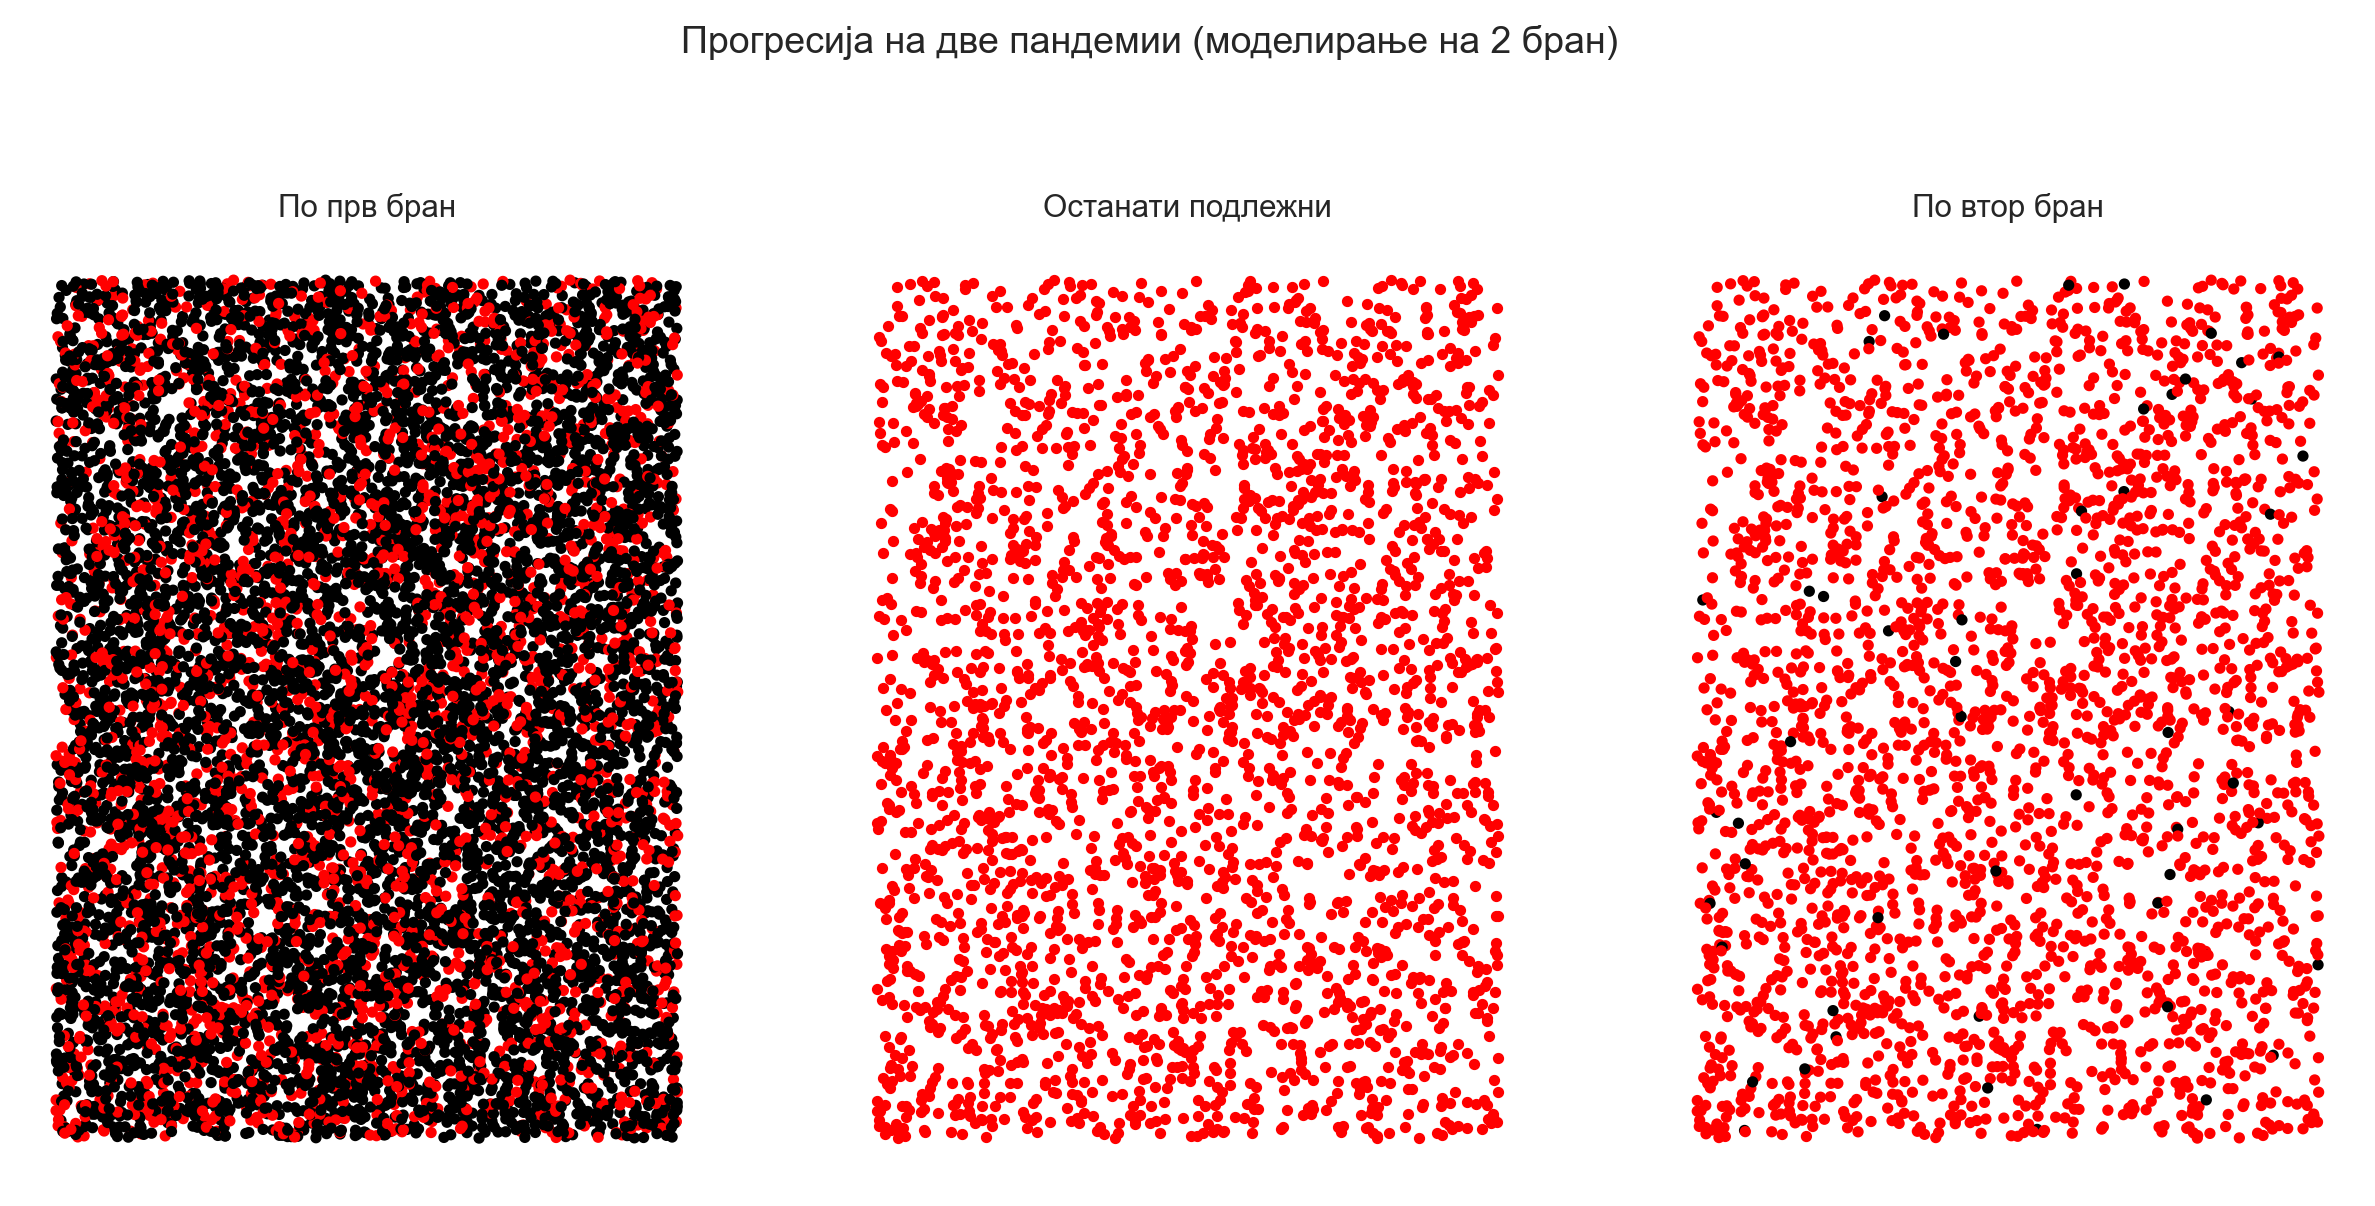

In [12]:
(fig,axs) = plt.subplots(1, 3, figsize=(12, 5))

# бои за сите состојби 
colours = dict()
colours[epydemic.SIR.SUSCEPTIBLE] = 'red'
colours[epydemic.SIR.INFECTED] = 'green'
colours[epydemic.SIR.REMOVED] = 'black'

# конечна мрежа на првата епидемија,
# боење за оддел
ax = axs[0]
final = m1.network()
pos1 = networkx.drawing.layout.random_layout(final)
ncs = [ colours[m1.getCompartment(n)] for n in final.nodes() ]
networkx.draw_networkx(final, pos=pos1, ax=ax,
                       node_color=ncs, node_size=5,
                       with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('По прв бран')

# преостаната мрежа за втора епидемија
ax = axs[1]
final = m2.network()
pos2 = { n: pos1[n] for n in pos1.keys() if n in final.nodes() }
networkx.draw_networkx(final, pos=pos2, ax=ax,
                       node_color=colours[epydemic.SIR.SUSCEPTIBLE],
                       node_size=5, with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('Останати подлежни')

# финална мрежа на секундарната пандемија
ax = axs[2]
ncs = [ colours[m2.getCompartment(n)] for n in final.nodes() ]
networkx.draw_networkx(final, pos=pos2, ax=ax,
                       node_color=ncs, node_size=5,
                       with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('По втор бран')

# fine-tune на фигура 
plt.suptitle('Прогресија на две пандемии (моделирање на 2 бран)', y=1.05)

# бројката што ја создадовме е голема - многу голема,
# всушност - поради големата мрежа. Бидејќи ние
# не сакаме да создадеме голема тетратка, ние генерираме
# и зачувајте ја датотеката # без да ја прикажете, а потоа
# повторно вчитајте ја зачуваната слика
# plt.savefig('images/4_herd-finals.png', dpi=280, bbox_inches='tight')
_ = plt.show()

Во најлевиот панел ја имаме мрежата по првата епидемија, со **црни јазли** оние што биле заразени. Во средниот панел ги отстрануваме овие јазли, оставајќи ги само **преостанатите подлежни**. (Не ги нацртавме рабовите заради обемот на популацијата) Во десната табла ја прикажуваме мрежата по втората епидемија (вториот бран) - внимателно погледнете за да ги пронајдете јазлите што биле заразени! 

Визуелниот прв впечаток е она што е важно, иако: по првата епидемија мрежата беше претежно заразена, но по втората таа беше во голема мера недопрена и покрај фактот дека истата болест беше воведена и двапати. 

Населението се стасклано со колективен имунитет својот прв бран со оваа болест. И покрај тоа што некои луѓе беа заразени, болеста никогаш не се задржа по втор пат.

## Комплексноста на имунитет

Сметам дека овие симулаци се симплфикација на вистинскиот свет. Овие симулации ги прават работите да звучат едноставни. Инфицирањето на популацијата еднаш значи дека тие, како тело, не можат повторно да се заразат и затоа ризиците од последователни епидемии на болести се минимизираат.

Не баш. Постојат повеќе работи што треба да ги разгледаме.

Прво, и што е најважно, стекнување имунитет на стадо преку инфекција значи дека многу луѓе треба да се разболат. Во зависност од болеста, тоа може да резултира во многу мизерија и многу смрт. Ја разгледавме разликата помеѓу овие два фактори во користењето на SIR како наш модел на болест, но треба да запомниме дека „отстранет“ (во смисла на SIR) ги вклучува и оние кои се опоравиле и оние кои починале - никој од нив, во оваа едноставна модел, земете понатамошно учество во оваа или идната епидемија.

Иако разликата помеѓу опоравување и мртвост не е важна математички, таа е многу важна за засегнатите индивидуи - поточно, важна е за оние што преживуваат. Ако болест со дури ниска стапка на смртност зарази 60% од популацијата што сепак потенцијално значи многу смртни случаи.

Второ, понатамошна претпоставка за SIR е дека имунитетот е бинарен настан: еден е или подложен или отстранет, и ако е подложен, тој е целосно подложен и ако е отстранет, тој е целосно отстранет. Ако некој се зарази, се менува моментално помеѓу овие две класи. Овие претпоставки не се точен модел на вистински болести.

Кај многу болести, инфекцијата од болеста дава само **делумен имунитет (partialy immune)** на понатамошна инфекција. Во суштина, ова ја намалува личната веројатност на сопствената личност $p_{infect}$, што ги прави помалку веројатно да бидат заразени на следните средби.

Кај други болести, инфекцијата дава **привремен имунитет (temporary immunity)**, така што $p_{infect}$ на поединецот се менува со текот на времето, можеби паѓа на нула веднаш по закрепнувањето и се зголемува со текот на времето. Точниот начин на распаѓање на имунитетот може да биде различен, можеби стабилно се зголемува или можеби скока, а можеби на крајот достигнува „нормално“ ниво како да не се случила првата инфекција. И, се разбира, секогаш може да се има случај на привремен парцијален имунитет кој ги комбинира одликите на обете.

На овие комплексности треба да додадеме и несигурност. Во епидемија на ново заболување, скоро сигурно не знаеме што дава, доколку има, инфекција со имунитет. Ова подразбира дека не знаеме дали повторувањето на болеста ќе резултира со друга епидемија или не.

Сето ова значи дека постигнувањето **имунитет на стадото** не е одржлива стратегија за управување со нови болести со големи потенцијални епидемиски големини, дури и ако се знае (или се претпоставува) дека имаат релативно ниска стапка на смртност ($\alpha$). Мал дел од голем број сè уште може да биде значителен. За среќа, имунитетот на стадото не е единствената стратегија за управување што ја имаме на располагање и најдобриот начин е преку воведување на вакцинирање. 